In [1]:
import pyspark
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


In [2]:
os.chdir('../Project/finding-elo/')
sc = pyspark.SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [3]:
games = sc.textFile('data_uci.pgn')
games = games.map(lambda l:l.rstrip())

In [4]:
def myfunc(a):
    if "1/2" in a:
        return 0
    if "1-0" in a:
        return 1
    else:
        return -1

def eval_moves(moves):
    score = 0
    for i in range(len(moves)-1):
        score = score + moves[i+1] - moves[i]
    return score
        

In [5]:
result = games.filter(lambda l:"Result" in l).map(lambda l: myfunc(l)).zipWithIndex().filter(lambda vi: vi[1] < 25000).map(lambda l:(l[1],l[0]))
whiteelo = games.filter(lambda l: "WhiteElo" in l).map(lambda l:int(l.split()[1][1:5])).zipWithIndex().map(lambda l:(l[1],l[0]))
blackelo = games.filter(lambda l: "BlackElo" in l).map(lambda l:int(l.split()[1][1:5])).zipWithIndex().map(lambda l:(l[1],l[0]))
stockfish = sc.textFile('stockfish.csv').filter(lambda l: 'Event' not in l).map(lambda l:[0]+[int(x) for x in l.split(',')[1].split(" ") if x!=''])\
.map(lambda l: eval_moves(l)).zipWithIndex().filter(lambda vi: vi[1] < 25000).map(lambda l:(l[1],l[0]))


In [6]:
temp = whiteelo.join(blackelo).join(result).join(stockfish).map(lambda l:[l[1][0][0][0],l[1][0][0][1],l[1][0][0][0]-l[1][0][0][1],l[1][0][1],l[1][1]])
df = temp.toDF(['white_rating','black_rating','rating_diff','result','score'])


In [7]:
vectorAssembler = VectorAssembler(inputCols = ['rating_diff','result','score'], outputCol = "features")
df = vectorAssembler.transform(df)
white_df = df.select(['features', 'white_rating'])
black_df = df.select(['features','black_rating'])


splits = white_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

rf = RandomForestRegressor(featuresCol="features",labelCol='white_rating',maxDepth=25,numTrees=25)
rf_model_white = rf.fit(train_df)
rf_predictions = rf_model_white.transform(test_df)
rf_predictions.select("prediction","white_rating","features").show(5)


+------------------+------------+--------------------+
|        prediction|white_rating|            features|
+------------------+------------+--------------------+
|2387.6970611206807|        2375|           (3,[],[])|
| 1888.331681651849|        1467|[-652.0,-1.0,-538...|
|1967.7518975584417|        1895|[-638.0,-1.0,-285.0]|
| 1959.756475527984|        1361|[-617.0,-1.0,-521.0]|
|1970.3702441544347|        1781|[-613.0,-1.0,-355.0]|
+------------------+------------+--------------------+
only showing top 5 rows



In [8]:
evaluator = RegressionEvaluator(
    labelCol="white_rating", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(rf_predictions)
print("MAE on test data = %g" % mae)

MAE on test data = 186.347


(1000, 3000)

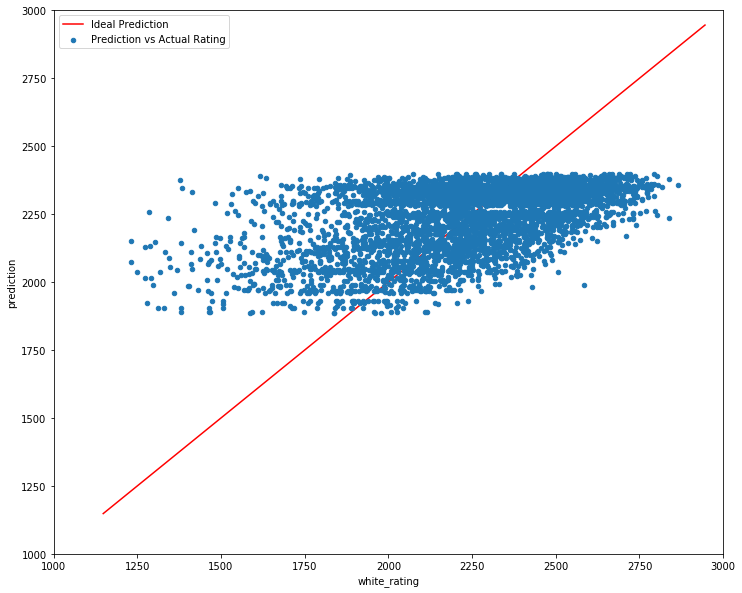

In [9]:
x=rf_predictions.toPandas()
ax=x.plot.scatter(x='white_rating',y='prediction',figsize=(12,10),label='Prediction vs Actual Rating')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims,'r' ,zorder=0,label='Ideal Prediction')
ax.legend()
ax.set_xlim([1000,3000])
ax.set_ylim([1000,3000])



In [10]:
splits = black_df.randomSplit([0.8, 0.2])
train_df = splits[0]
test_df = splits[1]

rf = RandomForestRegressor(featuresCol="features",labelCol='black_rating',maxDepth=25,numTrees=25)
rf_model_black = rf.fit(train_df)
rf_predictions = rf_model_black.transform(test_df)
rf_predictions.select("prediction","black_rating","features").show(5)



+------------------+------------+--------------------+
|        prediction|black_rating|            features|
+------------------+------------+--------------------+
|2401.0431974469393|        2296|           (3,[],[])|
|2312.9163011347214|        1954|[-706.0,-1.0,-149...|
|2359.6883499386568|        2468|[-684.0,-1.0,-450.0]|
|2361.6512054607906|        2638|[-676.0,-1.0,-601.0]|
| 2281.336555996588|        2459| [-664.0,1.0,-398.0]|
+------------------+------------+--------------------+
only showing top 5 rows



In [11]:
evaluator = RegressionEvaluator(
    labelCol="black_rating", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(rf_predictions)
print("MAE on test data = %g" % mae)

MAE on test data = 182.011


(1000, 3000)

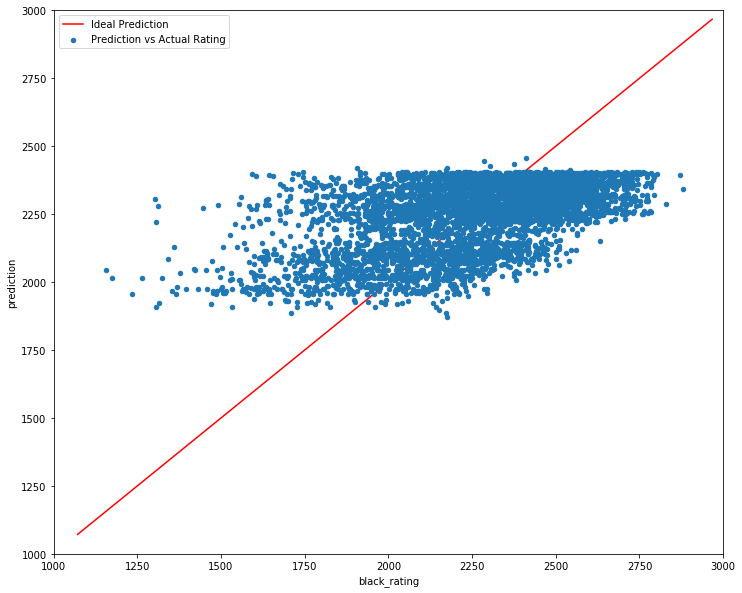

In [12]:
x=rf_predictions.toPandas()
ax=x.plot.scatter(x='black_rating',y='prediction',figsize=(12,10),label='Prediction vs Actual Rating')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims,'r' ,zorder=0,label='Ideal Prediction')
ax.legend()
ax.set_xlim([1000,3000])
ax.set_ylim([1000,3000])




